In [1]:
!pip install gdown
import os
import zipfile
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
import gdown
import zipfile
file_id = "1doUhVoq1-c9pamZVLpvjW1YRDMkKO1Q5"
output = "dataset.zip"
gdown.download(f"https://drive.google.com/uc?id={file_id}", output, quiet = False)

with zipfile.ZipFile("dataset.zip", "r") as zip_ref:
  zip_ref.extractall("/content/dataset")

Downloading...
From (original): https://drive.google.com/uc?id=1doUhVoq1-c9pamZVLpvjW1YRDMkKO1Q5
From (redirected): https://drive.google.com/uc?id=1doUhVoq1-c9pamZVLpvjW1YRDMkKO1Q5&confirm=t&uuid=21d4235b-eaa1-4836-90b3-977cbad0958a
To: /content/dataset.zip
100%|██████████| 2.11G/2.11G [00:17<00:00, 124MB/s]


In [3]:
data_dir = "/content/dataset"
train_lens_dir = os.path.join(data_dir, 'train_lenses')
train_nonlens_dir = os.path.join(data_dir, 'train_nonlenses')
test_lens_dir = os.path.join(data_dir, 'test_lenses')
test_nonlens_dir = os.path.join(data_dir, 'test_nonlenses')

In [7]:
class LensingDataset(Dataset):
  def __init__(self, lenses_dir, non_lenses_dir, transform = None):
    self.transform = None
    self.image_paths = []
    self.labels = []

    for file in os.listdir(lenses_dir):
      if file.endswith('.npy'):
        self.image_paths.append(os.path.join(lenses_dir, file))
        self.labels.append(1)

    for file in os.listdir(non_lenses_dir):
      if file.endswith('.npy'):
        self.image_paths.append(os.path.join(non_lenses_dir, file))
        self.labels.append(0)

    self.labels = torch.tensor(self.labels, dtype = torch.long)

  def __len__(self):
    return len(self.image_paths)

  def __getitem__(self, idx):
    image = np.load(self.image_paths[idx])
    image = torch.tensor(image, dtype = torch.float32)
    label = self.labels[idx]

    if self.transform:
      image = self.transform(image)

    return image, label

In [5]:
transform = transforms.Compose([
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [8]:
train_dataset = LensingDataset(train_lens_dir, train_nonlens_dir, transform=transform)
test_dataset = LensingDataset(test_lens_dir, test_nonlens_dir, transform=transform)

In [9]:
class_counts = torch.bincount(train_dataset.labels)
class_weights = 1.0 / class_counts.float()
sample_weights = class_weights[train_dataset.labels]
sampler = torch.utils.data.WeightedRandomSampler(sample_weights, len(sample_weights))

In [10]:
train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

In [11]:
for images, labels in train_loader:
    print("Image shape:", images.shape)
    print("Image dtype:", images.dtype)
    break

Image shape: torch.Size([32, 3, 64, 64])
Image dtype: torch.float32


In [25]:
def initialize_model(model_name):
  if model_name == "resnet18":
    model = models.resnet18(pretrained = True)
    model.fc = nn.Linear(model.fc.in_features, 1)
  elif model_name == "efficientnet_b0":
    model = models.efficientnet_b0(pretrained = True)
    model.classifier = nn.Linear(model.classifier[1].in_features, 1)
  else:
    raise ValueError("Invalid model name")

  model.cuda()
  return model

In [26]:
def train_model(model, train_loader, criterion, optimizer, epochs=5, accumulation_steps=4):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        optimizer.zero_grad()

        for i, (images, labels) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}")):
            images, labels = images.cuda(), labels.float().cuda()
            labels = labels.unsqueeze(1)

            outputs = model(images)
            loss = criterion(outputs, labels) / accumulation_steps
            loss.backward()

            if (i + 1) % accumulation_steps == 0 or (i + 1) == len(train_loader):
                optimizer.step()
                optimizer.zero_grad()

            running_loss += loss.item() * accumulation_steps

        print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader)}")

In [27]:
def evaluate_model(model, test_loader):
    model.eval()
    y_true, y_scores = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.cuda()
            outputs = model(images)
            probs = torch.sigmoid(outputs).cpu().numpy()
            y_true.extend(labels.numpy())
            y_scores.extend(probs)

    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

    print(f'AUC Score: {roc_auc:.3f}')
    return roc_auc

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1: 100%|██████████| 951/951 [00:20<00:00, 46.32it/s]


Epoch 1, Loss: 0.14308672566574016


Epoch 2: 100%|██████████| 951/951 [00:20<00:00, 46.29it/s]


Epoch 2, Loss: 0.05049746803749357


Epoch 3: 100%|██████████| 951/951 [00:21<00:00, 44.93it/s]


Epoch 3, Loss: 0.02576891102820557


Epoch 4: 100%|██████████| 951/951 [00:19<00:00, 47.68it/s]


Epoch 4, Loss: 0.021473982412551433


Epoch 5: 100%|██████████| 951/951 [00:20<00:00, 46.47it/s]

Epoch 5, Loss: 0.014480781113818182


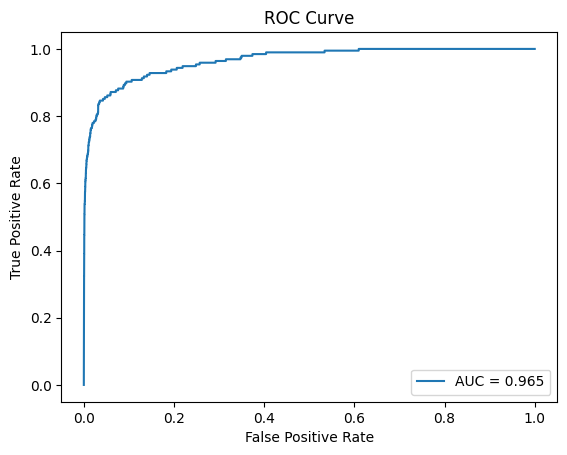

AUC Score: 0.965


In [28]:
model_resnet = initialize_model('resnet18')
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model_resnet.parameters(), lr=0.0001)
train_model(model_resnet, train_loader, criterion, optimizer)
auc_resnet = evaluate_model(model_resnet, test_loader)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1: 100%|██████████| 951/951 [00:39<00:00, 24.03it/s]


Epoch 1, Loss: 0.30337745098536195


Epoch 2: 100%|██████████| 951/951 [00:39<00:00, 24.25it/s]


Epoch 2, Loss: 0.15142699273853522


Epoch 3: 100%|██████████| 951/951 [00:38<00:00, 24.55it/s]


Epoch 3, Loss: 0.1088519310941048


Epoch 4: 100%|██████████| 951/951 [00:39<00:00, 24.05it/s]


Epoch 4, Loss: 0.08418019965866856


Epoch 5: 100%|██████████| 951/951 [00:38<00:00, 24.42it/s]

Epoch 5, Loss: 0.06216175417287508


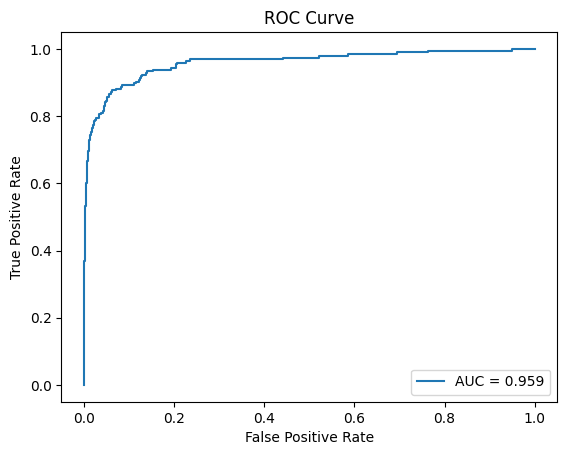

AUC Score: 0.959


In [29]:
model_efficientnet = initialize_model('efficientnet_b0')
optimizer = optim.Adam(model_efficientnet.parameters(), lr=0.0001)
train_model(model_efficientnet, train_loader, criterion, optimizer)
auc_efficientnet = evaluate_model(model_efficientnet, test_loader)

In [30]:
print(f"ResNet18 AUC: {auc_resnet:.3f}")
print(f"EfficientNet B0 AUC: {auc_efficientnet:.3f}")

ResNet18 AUC: 0.965
EfficientNet B0 AUC: 0.959
